# Synthesizing Data 
## By: Lela Bones
-----------------------------------
### Problem
    Nestor is an application that allows users to datify their maintenance logs. Datify is the process of taking unorginized data and putting it into a quantifiable and statistically relevant format. The problem is that because of copywright and data ownership technicalities, it is hard for us to have a large amount of "good" data to demo our app on. 

### Solution
    I plan on using Reccurent Neural Nets (RNNs) to generate realistic data from the data that we already have from companies. The reason for this is because we can use the "synthetic" data to demo our app on, and we aren't breaking any laws. I plan on using a Python library, Pytorch to implement my RNN and train it on the data. 

#### Why Pytorch???
Pytorch is a framework that builds from the Torch framework that Facebook actively uses. Pytorch is extremely fast it is very native and customizable. Pytorch is also a dynamic deep learning tool, which means that you can change and execute notes as you're learning. This makes RNNs way easier to train because you don't need to set a maximum length and then pad smaller sequences. Debugging is really easy because it is defined at runtime. It works well with Flask, which is the tool that I am using to create my visual dashboard. Pytorch also has declarative data parallelism which allows you to use multiple GPUs. 

#### Why RNNs???
    * Vanilla Neural Networks relearn each iteration
    * Long Short Term Memory Neural Nets are good for long-term data
    * Maybe GRU Neural Nets, they get rid of the disappearing gradient problem
    * RNNs implement loops so the learning is compositional

### Data manipulation

In [32]:
#conda install pandas
#conda install pytorch torchvision -c pytorch
#conda install numpy
import pandas as pd
import torch
import numpy as np

In [33]:
#set data file, column you want extracted, and output file
csv_file = 'mine_raw.csv'
txt_file = 'train.txt'
text_col = 'OriginalShorttext'

In [34]:
#this function converts the column of text from your csv file 
#to a text file that has each row on a seperate line
#code modified from https://stackoverflow.com/questions/47339698/how-to-convert-csv-file-to-text-file-using-python
def createTextFile(inputFile, text, outputFile):
    df = pd.read_csv(inputFile)
    data = df[text].apply(lambda x: " ".join(x.lower() for x in x.split()))

    text_list = []
    for line in data:
        text_list.append(" ".join(line))
    
    #switch to a+ if you want to append to existing file
    with open(outputFile, "w+") as output_file:
        for line in data:
            output_file.write("  " + line + "\n")
        #verification that it's finished
        print('File Successfully written.')
    output_file.close()

In [35]:
createTextFile(csv_file, text_col, txt_file)

File Successfully written.


## First Attempt
The majority of this code was modified from https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb


In [5]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open(txt_file).read())
file_len = len(file)
print('file_len =', file_len)

file_len = 165817


In [6]:
chunk_len = 200

#splitting up the code into random chunks each the size of 200
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# print(random_chunk())

### Creating the Neural Net

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [8]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [10]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

In [13]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/msid/ltb3/anaconda3/envs/nestorDev/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


 37s (100 5%) 1.8912]
Wh6KR6h6HLB
  rick trotstho
  don leakin ol tup stir takt alg bo r/h oling
  wir ang sil wrepam moan n 

 19s (200 10%) 2.0013]
Whss on woth shyd 24104
  replace hose line hose out
  replh r/h prepace line l/h  hyd liling l/h buck 

 56s (300 15%) 1.4132]
Whand motoat switexs
  harmids leak ~ rh engine pump
  replace ~ talank leaking leake)
  replace chang 

 35s (400 20%) 1.1199]
Whk mairs
  repair repair bucket start toom hfidys
  al bext oils not working
  reasre looth over toor 

 18s (500 25%) 1.1332]
Wh hand ring ousing aproken eal shd24
  replace boom alant
  replace arem fileget filtern pressins
  r 

 1s (600 30%) 1.0488]
Wh slew bot on bolts oulter start under
  cramp broken grease shd 4 replace coor 4
  replace for ganer 

 44s (700 35%) 1.4145]
Wh bucket top
  rh alarr shd24.
  repair and shd0024
  repair bucket tooth
  repair aday grease
  repa 

 19s (800 40%) 1.2525]
Wh fire rimessor wofff pump senters
  replace block in creplaces splate ring
  wate

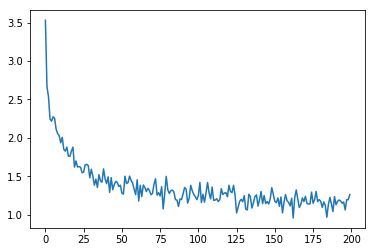

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Second Attempt
Most of this code is from https://github.com/mcleonard/pytorch-charRNN/blob/master/TorchRNN.ipynb

In [36]:
#importing necessary libraries
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

In [37]:
#read in data
with open (txt_file, 'r') as f:
    text = f.read()

In [38]:
#convert char to int
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in text])

In [39]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns mini-batches of size
       n_seqs x n_steps from arr.
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [40]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        self.init_weights()
        
    def forward(self, x, hc):
        ''' Forward pass through the network '''
        
        x, (h, c) = self.lstm(x, hc)
        x = self.dropout(x)
        
        # Stack up LSTM outputs
        x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        x = self.fc(x)
        
        return x, (h, c)
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = Variable(torch.from_numpy(x), volatile=True)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([Variable(each.data, volatile=True) for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()),
                Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()))

In [41]:
def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Traing a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = Variable(x), Variable(y)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([Variable(each.data) for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([Variable(each.data, volatile=True) for each in val_h])
                    
                    inputs, targets = Variable(x, volatile=True), Variable(y, volatile=True)
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))
                
                    val_losses.append(val_loss.data[0])
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.data[0]),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [43]:
if 'net' in locals():
    del net



net = CharRNN(chars, n_hidden=512, n_layers=2)

n_seqs, n_steps = 10, 50
train(net, encoded, epochs=25, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=True, print_every=10)


/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to

Epoch: 1/25... Step: 10... Loss: 3.1611... Val Loss: 3.1850
Epoch: 1/25... Step: 20... Loss: 3.0247... Val Loss: 3.0601
Epoch: 1/25... Step: 30... Loss: 2.8449... Val Loss: 2.9841
Epoch: 1/25... Step: 40... Loss: 2.7697... Val Loss: 2.9044
Epoch: 1/25... Step: 50... Loss: 2.7963... Val Loss: 2.8121
Epoch: 1/25... Step: 60... Loss: 2.5574... Val Loss: 2.7220
Epoch: 1/25... Step: 70... Loss: 2.3822... Val Loss: 2.6780
Epoch: 1/25... Step: 80... Loss: 2.2556... Val Loss: 2.6236
Epoch: 1/25... Step: 90... Loss: 2.2579... Val Loss: 2.6238
Epoch: 1/25... Step: 100... Loss: 2.2720... Val Loss: 2.5818
Epoch: 1/25... Step: 110... Loss: 2.2795... Val Loss: 2.5855
Epoch: 1/25... Step: 120... Loss: 2.2292... Val Loss: 2.5649
Epoch: 1/25... Step: 130... Loss: 1.9819... Val Loss: 2.5388
Epoch: 1/25... Step: 140... Loss: 1.8547... Val Loss: 2.5047
Epoch: 1/25... Step: 150... Loss: 2.0360... Val Loss: 2.5264
Epoch: 1/25... Step: 160... Loss: 1.9774... Val Loss: 2.5154
Epoch: 1/25... Step: 170... Loss:

Epoch: 5/25... Step: 1350... Loss: 1.1337... Val Loss: 1.8069
Epoch: 5/25... Step: 1360... Loss: 1.1393... Val Loss: 1.8584
Epoch: 5/25... Step: 1370... Loss: 1.1240... Val Loss: 1.8296
Epoch: 5/25... Step: 1380... Loss: 1.0045... Val Loss: 1.8408
Epoch: 5/25... Step: 1390... Loss: 1.2977... Val Loss: 1.8220
Epoch: 5/25... Step: 1400... Loss: 1.0608... Val Loss: 1.7783
Epoch: 5/25... Step: 1410... Loss: 1.0186... Val Loss: 1.7783
Epoch: 5/25... Step: 1420... Loss: 1.2059... Val Loss: 1.7692
Epoch: 5/25... Step: 1430... Loss: 1.1771... Val Loss: 1.7754
Epoch: 5/25... Step: 1440... Loss: 1.0417... Val Loss: 1.7918
Epoch: 5/25... Step: 1450... Loss: 1.2134... Val Loss: 1.7861
Epoch: 5/25... Step: 1460... Loss: 0.9494... Val Loss: 1.7721
Epoch: 5/25... Step: 1470... Loss: 1.1761... Val Loss: 1.7871
Epoch: 5/25... Step: 1480... Loss: 1.0474... Val Loss: 1.7894
Epoch: 5/25... Step: 1490... Loss: 1.1727... Val Loss: 1.7464
Epoch: 6/25... Step: 1500... Loss: 1.0800... Val Loss: 1.8085
Epoch: 6

Epoch: 9/25... Step: 2680... Loss: 1.1420... Val Loss: 1.7013
Epoch: 10/25... Step: 2690... Loss: 0.9009... Val Loss: 1.7194
Epoch: 10/25... Step: 2700... Loss: 0.9752... Val Loss: 1.7358
Epoch: 10/25... Step: 2710... Loss: 0.9609... Val Loss: 1.6884
Epoch: 10/25... Step: 2720... Loss: 0.7515... Val Loss: 1.7004
Epoch: 10/25... Step: 2730... Loss: 0.9217... Val Loss: 1.7725
Epoch: 10/25... Step: 2740... Loss: 0.8611... Val Loss: 1.6859
Epoch: 10/25... Step: 2750... Loss: 0.8408... Val Loss: 1.7114
Epoch: 10/25... Step: 2760... Loss: 0.9955... Val Loss: 1.7358
Epoch: 10/25... Step: 2770... Loss: 0.8379... Val Loss: 1.7297
Epoch: 10/25... Step: 2780... Loss: 0.8658... Val Loss: 1.7221
Epoch: 10/25... Step: 2790... Loss: 1.0940... Val Loss: 1.7037
Epoch: 10/25... Step: 2800... Loss: 0.9385... Val Loss: 1.7300
Epoch: 10/25... Step: 2810... Loss: 0.9872... Val Loss: 1.7241
Epoch: 10/25... Step: 2820... Loss: 0.9370... Val Loss: 1.6729
Epoch: 10/25... Step: 2830... Loss: 0.9378... Val Loss: 

Epoch: 14/25... Step: 3990... Loss: 0.8003... Val Loss: 1.7717
Epoch: 14/25... Step: 4000... Loss: 0.8845... Val Loss: 1.7736
Epoch: 14/25... Step: 4010... Loss: 0.6979... Val Loss: 1.7523
Epoch: 14/25... Step: 4020... Loss: 0.7941... Val Loss: 1.7261
Epoch: 14/25... Step: 4030... Loss: 0.7081... Val Loss: 1.7678
Epoch: 14/25... Step: 4040... Loss: 0.7126... Val Loss: 1.8138
Epoch: 14/25... Step: 4050... Loss: 0.7774... Val Loss: 1.7988
Epoch: 14/25... Step: 4060... Loss: 0.9230... Val Loss: 1.7896
Epoch: 14/25... Step: 4070... Loss: 0.7760... Val Loss: 1.7591
Epoch: 14/25... Step: 4080... Loss: 0.8882... Val Loss: 1.6998
Epoch: 14/25... Step: 4090... Loss: 0.8183... Val Loss: 1.6846
Epoch: 14/25... Step: 4100... Loss: 0.8198... Val Loss: 1.7089
Epoch: 14/25... Step: 4110... Loss: 0.8521... Val Loss: 1.6779
Epoch: 14/25... Step: 4120... Loss: 0.8922... Val Loss: 1.7482
Epoch: 14/25... Step: 4130... Loss: 0.7692... Val Loss: 1.7283
Epoch: 14/25... Step: 4140... Loss: 0.7466... Val Loss:

Epoch: 18/25... Step: 5300... Loss: 0.8838... Val Loss: 1.7483
Epoch: 18/25... Step: 5310... Loss: 0.6798... Val Loss: 1.7853
Epoch: 18/25... Step: 5320... Loss: 0.6859... Val Loss: 1.8355
Epoch: 18/25... Step: 5330... Loss: 0.6858... Val Loss: 1.8288
Epoch: 18/25... Step: 5340... Loss: 0.6159... Val Loss: 1.8124
Epoch: 18/25... Step: 5350... Loss: 0.7209... Val Loss: 1.8015
Epoch: 18/25... Step: 5360... Loss: 0.7261... Val Loss: 1.7811
Epoch: 19/25... Step: 5370... Loss: 0.6985... Val Loss: 1.8407
Epoch: 19/25... Step: 5380... Loss: 0.8782... Val Loss: 1.8971
Epoch: 19/25... Step: 5390... Loss: 0.7805... Val Loss: 1.8077
Epoch: 19/25... Step: 5400... Loss: 0.6960... Val Loss: 1.8213
Epoch: 19/25... Step: 5410... Loss: 0.6038... Val Loss: 1.8428
Epoch: 19/25... Step: 5420... Loss: 0.6882... Val Loss: 1.8982
Epoch: 19/25... Step: 5430... Loss: 0.7982... Val Loss: 1.8297
Epoch: 19/25... Step: 5440... Loss: 0.7573... Val Loss: 1.7898
Epoch: 19/25... Step: 5450... Loss: 0.7558... Val Loss:

Epoch: 23/25... Step: 6610... Loss: 0.6313... Val Loss: 1.9865
Epoch: 23/25... Step: 6620... Loss: 0.6260... Val Loss: 1.9282
Epoch: 23/25... Step: 6630... Loss: 0.8103... Val Loss: 1.8960
Epoch: 23/25... Step: 6640... Loss: 0.6203... Val Loss: 1.9500
Epoch: 23/25... Step: 6650... Loss: 0.5773... Val Loss: 1.9441
Epoch: 23/25... Step: 6660... Loss: 0.6413... Val Loss: 1.9466
Epoch: 23/25... Step: 6670... Loss: 0.7009... Val Loss: 1.9344
Epoch: 23/25... Step: 6680... Loss: 0.7015... Val Loss: 1.9744
Epoch: 23/25... Step: 6690... Loss: 0.6468... Val Loss: 1.9688
Epoch: 23/25... Step: 6700... Loss: 0.6273... Val Loss: 1.9437
Epoch: 23/25... Step: 6710... Loss: 0.6839... Val Loss: 1.9111
Epoch: 23/25... Step: 6720... Loss: 0.5294... Val Loss: 1.9248
Epoch: 23/25... Step: 6730... Loss: 0.4539... Val Loss: 1.9954
Epoch: 23/25... Step: 6740... Loss: 0.7205... Val Loss: 2.0085
Epoch: 23/25... Step: 6750... Loss: 0.7168... Val Loss: 1.9608
Epoch: 23/25... Step: 6760... Loss: 0.6201... Val Loss:

In [44]:
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}
with open('rnn.net', 'wb') as f:
    torch.save(checkpoint, f)

In [45]:
def sample(net, size, prime='The', top_k=None, cuda=False):
        
    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda=cuda, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [49]:
print(sample(net, 20000, prime='re', top_k=2, cuda=False))

/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


rear oil cooler shd24
  changeout ~ right slew motor has failed
  repair hyd leak on hy distribution blocks
  repair cracks in control
  broken bolts on cab mounts
  replace rh eng coolant temp sensor
  replace r/h slew motor hoses
  replace r/h slew motor
  hydraulic leak on rh engine
  repair oil leak on r/h slew motor hoses
  changeout rh no1 track roller
  change out l/h slew motor
  repair oil leak
  replace hyd hose
  replace rhs slew motor
  repair oil leak on boom
  changeout ~ right hand track chain
  change out rh slew motor
  changeout ~ left hand slew motor
  change out r/h engine
  rh eng oil pump spline cavities & fit new bolts
  changeout rh slew motor
  repairs
  hyd leak
  repair hydraulic leak
  replace hyd hose on shutting dramas
  replace broken bolts
  replace rh slew motor hoses
  clamps on hand rail broken.
  cab mount bolt missing on bucket
  replace bucket teeth
  replace bucket tooth and keepers
  replace bucket tooth and keepers
  leaking hyd hose on starter


In [ ]:
with open('rnn.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

In [ ]:
print(sample(loaded, 2000, cuda=False, top_k=5, prime="replace"))